KeyboardInterrupt: 

c:\Users\35096\.conda\envs\tools\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimSun.
  func(*args, **kwargs)
c:\Users\35096\.conda\envs\tools\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimSun.
  fig.canvas.print_figure(bytes_io, **kw)


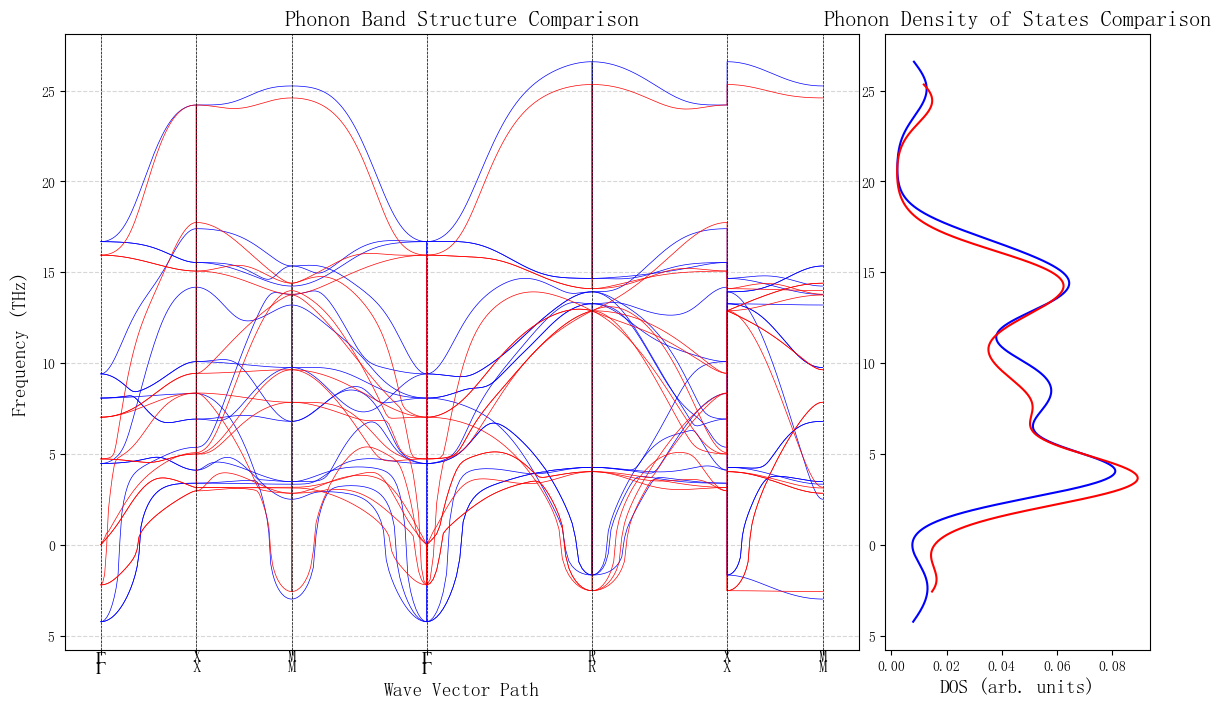

In [3]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib import gridspec

def calculate_path_length(qpoints, segment_nqpoint):
    """
    计算每个 q 点在路径上的累积距离。
    """
    path_length = [0]
    current_index = 0
    for nq in segment_nqpoint:
        for i in range(current_index, current_index + nq - 1):
            delta = np.linalg.norm(np.array(qpoints[i + 1]) - np.array(qpoints[i]))
            path_length.append(path_length[-1] + delta)
        current_index += nq
    return path_length

def read_band_yaml(band_yaml_path):
    """
    读取 band.yaml 文件并提取所需信息。

    返回:
    - frequencies: np.ndarray, 形状 (nqpoint, nbands)
    - distances: np.ndarray, 形状 (nqpoint,)
    - high_symmetry_distances: list of float
    - high_symmetry_labels: list of str
    """
    with open(band_yaml_path, 'r') as file:
        data = yaml.safe_load(file)
    
    nqpoint = data.get('nqpoint', 0)
    npath = data.get('npath', 0)
    segment_nqpoint = data.get('segment_nqpoint', [])
    labels_segments = data.get('labels', [])
    frequency_conversion = data.get('frequency_unit_conversion_factor', 1.0)
    
    phonon_data = data.get('phonon', [])
    if len(phonon_data) == 0:
        raise ValueError(f"phonon 数据为空，请检查 {band_yaml_path} 文件。")
    
    nbands = len(phonon_data[0]['band'])
    frequencies = np.zeros((nqpoint, nbands))
    distances = []
    
    for i, qpoint in enumerate(phonon_data):
        distances.append(qpoint['distance'])
        for band_idx, band in enumerate(qpoint['band']):
            frequencies[i, band_idx] = band['frequency'] * frequency_conversion
    
    distances = np.array(distances)
    
    # 计算高对称点的位置和标签
    high_symmetry_distances = []
    high_symmetry_labels = []
    current = 0
    high_symmetry_distances.append(distances[0])
    if labels_segments:
        high_symmetry_labels.append(labels_segments[0][0])  # 第一个高对称点标签
    else:
        high_symmetry_labels.append('')  # 默认标签为空
    
    for idx, nq in enumerate(segment_nqpoint):
        if idx < len(labels_segments):
            current += nq
            if current < len(distances):
                high_symmetry_distances.append(distances[current - 1])
                high_symmetry_labels.append(labels_segments[idx][1])
    
    if high_symmetry_distances[-1] != distances[-1]:
        high_symmetry_distances.append(distances[-1])
        if labels_segments:
            high_symmetry_labels.append(labels_segments[-1][1])
        else:
            high_symmetry_labels.append('')
    
    return frequencies, distances, high_symmetry_distances, high_symmetry_labels

def compute_dos(frequencies, dos_sigma=0.1, include_negative=True):
    """
    计算声子态密度（DOS）。

    参数:
    - frequencies: np.ndarray, 所有频率值
    - dos_sigma: float, 核密度估计的标准差
    - include_negative: bool, 是否包含负频率

    返回:
    - frequency_range: np.ndarray, 频率范围
    - dos: np.ndarray, DOS 值
    """
    all_frequencies = frequencies.flatten()
    
    if not include_negative:
        all_frequencies = all_frequencies[all_frequencies > 0]
    
    # kde = gaussian_kde(all_frequencies, bw_method=dos_sigma)
    kde = gaussian_kde(all_frequencies)
    frequency_range = np.linspace(all_frequencies.min(), all_frequencies.max(), 1000)
    dos = kde(frequency_range)
    
    return frequency_range, dos

def plot_phonon_band_structure_and_dos(band_yaml_paths, labels, colors, dos_sigma=0.1):
    """
    读取多个 phonopy 生成的 band.yaml 文件，绘制声子带结构和声子态密度（DOS）进行对比，
    并将 DOS 显示在声子谱的右边。

    参数:
    - band_yaml_paths: list of str, band.yaml 文件的路径
    - labels: list of str, 每个 band.yaml 文件对应的标签
    - colors: list of str, 每个 band.yaml 文件对应的颜色
    - dos_sigma: float, 用于核密度估计的标准差，控制 DOS 的平滑程度
    """
    if not (len(band_yaml_paths) == len(labels) == len(colors)):
        raise ValueError("band_yaml_paths, labels, and colors must have the same length.")
    
    # 创建图形和 GridSpec
    fig = plt.figure(figsize=(14, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.05)
    
    # 左边子图：声子带结构
    ax_band = plt.subplot(gs[0])
    
    # 右边子图：DOS
    ax_dos = plt.subplot(gs[1], sharey=ax_band)
    
    # Initialize variables to handle high symmetry points (assuming all files have the same path)
    high_symmetry_distances = None
    high_symmetry_labels = None
    y_min = np.inf
    y_max = -np.inf
    
    for idx, (path, label, color) in enumerate(zip(band_yaml_paths, labels, colors)):
        frequencies, distances, hs_distances, hs_labels = read_band_yaml(path)
        nbands = frequencies.shape[1]
        
        # 更新 y 轴范围
        current_min = np.min(frequencies)
        current_max = np.max(frequencies)
        if current_min < y_min:
            y_min = current_min
        if current_max > y_max:
            y_max = current_max
        
        # 绘制声子带结构
        for band in range(nbands):
            ax_band.plot(distances, frequencies[:, band], color=color, linewidth=0.5, label=label if (idx == 0 and band == 0) else "")
            # ax_band.plot(distances, frequencies[:, band], color=color, linewidth=0.5, label=label if (idx == 0 and band == 0) else "")
        
        # Store high symmetry points from the first file
        if idx == 0:
            high_symmetry_distances = hs_distances
            high_symmetry_labels = hs_labels
    
    # 添加高对称点的垂直线和标签
    for d, label in zip(high_symmetry_distances, high_symmetry_labels):
        ax_band.axvline(x=d, color='k', linestyle='--', linewidth=0.5)
        ax_band.text(d, y_min - (y_max - y_min)*0.05, label, 
                    horizontalalignment='center', verticalalignment='top', fontsize=12)
    
    # 设置 x 轴刻度
    ax_band.set_xticks(high_symmetry_distances)
    ax_band.set_xticklabels(high_symmetry_labels, fontsize=12)
    
    # 设置标签和标题
    ax_band.set_xlabel('Wave Vector Path', fontsize=14)
    ax_band.set_ylabel('Frequency (THz)', fontsize=14)
    ax_band.set_title('Phonon Band Structure Comparison', fontsize=16)
    
    # 设置 y 轴范围，考虑负频率
    ax_band.set_ylim(y_min - (y_max - y_min)*0.05, y_max + (y_max - y_min)*0.05)
    
    # 添加网格
    ax_band.grid(True, linestyle='--', alpha=0.5)
    
    # 绘制 DOS
    for path, label, color in zip(band_yaml_paths, labels, colors):
        frequencies, _, _, _ = read_band_yaml(path)
        # frequency_range, dos = compute_dos(frequencies, dos_sigma=dos_sigma)
        frequency_range, dos = compute_dos(frequencies)
        ax_dos.plot(dos, frequency_range, color=color, linewidth=1.5, label=label)
    
    # 设置 DOS 的标签和标题
    ax_dos.set_xlabel('DOS (arb. units)', fontsize=14)
    ax_dos.set_title('Phonon Density of States Comparison', fontsize=16)
    
    # 设置 y 轴范围
    ax_dos.set_ylim(ax_band.get_ylim())
    
    # 设置 x 轴范围
    combined_dos = []
    for path in band_yaml_paths:
        freqs, _, _, _ = read_band_yaml(path)
        # _, dos = compute_dos(freqs, dos_sigma=dos_sigma)
        _, dos = compute_dos(freqs)
        combined_dos.append(dos)
    max_dos = max([dos.max() for dos in combined_dos])
    ax_dos.set_xlim(0, max_dos * 1.1)
    
    # 添加网格
    ax_dos.grid(True, linestyle='--', alpha=0.5)
    
    # 添加图例
    ax_band.legend(loc='upper right')
    ax_dos.legend(loc='upper right')
    
    # 调整布局
    plt.tight_layout()
    
    # 显示图形
    plt.show()

if __name__ == "__main__":
    # 指定 band.yaml 文件的路径
    band_yaml_paths = ['band-lmp.yaml', 'band-vasp.yaml']  # 修改为实际路径
    labels = ['LAMMPS', 'VASP']  # 为每个数据集指定标签
    colors = ['blue', 'red']  # 为每个数据集指定颜色
    
    # 绘制声子带结构和 DOS 的对比，DOS 显示在右边
    plot_phonon_band_structure_and_dos(band_yaml_paths, labels, colors, dos_sigma=0.05)


C:\Users\35096\AppData\Local\Temp\ipykernel_53300\3640765412.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


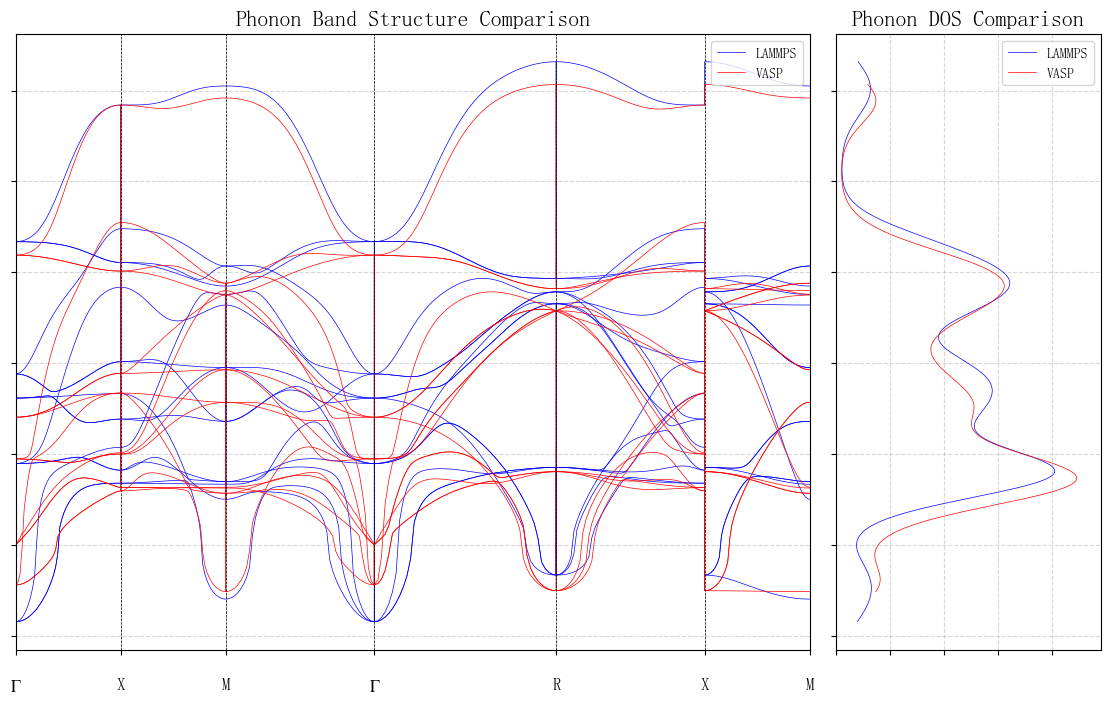

In [8]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib import gridspec
from typing import List, Tuple
import numpy.typing as npt
from matplotlib import rcParams

config = {
    "font.family": 'serif',
    # "font.size": 20,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)


class PhononData:
    """用于存储和处理声子数据的类"""

    def __init__(self, frequencies: npt.NDArray, distances: npt.NDArray,
                 hs_distances: List[float], hs_labels: List[str]):
        self.frequencies = frequencies
        self.distances = distances
        # 确保高对称点距离和标签数量相同
        if len(hs_distances) != len(hs_labels):
            min_len = min(len(hs_distances), len(hs_labels))
            self.hs_distances = hs_distances[:min_len]
            self.hs_labels = hs_labels[:min_len]
        else:
            self.hs_distances = hs_distances
            self.hs_labels = hs_labels
        self._cached_dos = None
        self._cached_freq_range = None


def read_band_yaml(band_yaml_path: str) -> PhononData:
    """优化的band.yaml文件读取函数"""
    with open(band_yaml_path, 'r') as file:
        data = yaml.safe_load(file)

    phonon_data = data.get('phonon', [])
    if not phonon_data:
        raise ValueError(f"phonon数据为空: {band_yaml_path}")

    nqpoint = len(phonon_data)
    nbands = len(phonon_data[0]['band'])
    frequencies = np.zeros((nqpoint, nbands))
    distances = np.zeros(nqpoint)

    freq_conversion = data.get('frequency_unit_conversion_factor', 1.0)
    for i, qpoint in enumerate(phonon_data):
        distances[i] = qpoint['distance']
        frequencies[i] = [band['frequency'] for band in qpoint['band']]
    frequencies *= freq_conversion

    # 改进的高对称点处理
    segment_nqpoint = data.get('segment_nqpoint', [])
    labels_segments = data.get('labels', [])

    if not segment_nqpoint or not labels_segments:
        # 如果没有分段信息，使用起点和终点
        hs_distances = [distances[0], distances[-1]]
        hs_labels = ['Γ', 'X']  # 默认标签
    else:
        # 计算累积点数
        cumulative_points = np.cumsum([0] + segment_nqpoint)
        hs_distances = []
        hs_labels = []

        # 添加第一个点
        hs_distances.append(distances[0])
        hs_labels.append(labels_segments[0][0])

        # 添加中间点
        for i, idx in enumerate(cumulative_points[1:-1]):
            if idx < len(distances):
                hs_distances.append(distances[idx])
                hs_labels.append(labels_segments[i][1])

        # 添加最后一个点
        if cumulative_points[-1] <= len(distances):
            hs_distances.append(distances[-1])
            hs_labels.append(labels_segments[-1][1])

    return PhononData(frequencies, distances, hs_distances, hs_labels)


def compute_dos(phonon_data: PhononData, dos_sigma: float = 0.1) -> Tuple[npt.NDArray, npt.NDArray]:
    """优化的DOS计算函数"""
    if phonon_data._cached_dos is not None:
        return phonon_data._cached_freq_range, phonon_data._cached_dos

    all_frequencies = phonon_data.frequencies.ravel()
    # kde = gaussian_kde(all_frequencies, bw_method=dos_sigma)
    kde = gaussian_kde(all_frequencies)

    freq_min, freq_max = all_frequencies.min(), all_frequencies.max()
    frequency_range = np.linspace(freq_min, freq_max, 500)
    dos = kde(frequency_range)

    phonon_data._cached_freq_range = frequency_range
    phonon_data._cached_dos = dos

    return frequency_range, dos


def plot_phonon_band_structure_and_dos(band_yaml_paths: List[str],
                                       labels: List[str],
                                       colors: List[str],
                                       dos_sigma: float = 0.1) -> None:
    """优化的绘图函数"""
    if not (len(band_yaml_paths) == len(labels) == len(colors)):
        raise ValueError("输入参数长度不匹配")

    fig = plt.figure(figsize=(14, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.05)
    ax_band = plt.subplot(gs[0])
    ax_dos = plt.subplot(gs[1], sharey=ax_band)

    phonon_datasets = [read_band_yaml(path) for path in band_yaml_paths]

    all_freqs = np.concatenate([data.frequencies.ravel()
                               for data in phonon_datasets])
    y_min, y_max = all_freqs.min(), all_freqs.max()
    y_padding = (y_max - y_min) * 0.05

    # 绘制声子带结构
    for idx, (data, label, color) in enumerate(zip(phonon_datasets, labels, colors)):
        for band in range(data.frequencies.shape[1]):
            ax_band.plot(data.distances, data.frequencies[:, band],
                         color=color, linewidth=0.5,
                         label=label if band == 0 else "")

    # 使用第一个数据集的高对称点
    reference_data = phonon_datasets[0]

    # 确保高对称点和标签数量匹配
    for d, l in zip(reference_data.hs_distances, reference_data.hs_labels):
        ax_band.axvline(x=d, color='k', linestyle='--', linewidth=0.5)
        ax_band.text(d, y_min - y_padding-1.5, l,
                     horizontalalignment='center',
                     verticalalignment='top',
                     fontsize=12)

    # 设置刻度
    ax_band.set_xticks(reference_data.hs_distances)
    ax_band.set_xticklabels([])  # 移除默认刻度标签，因为我们已经用text添加了标签
    ax_dos.set_yticklabels([])
    ax_dos.set_xticklabels([])

    # 绘制DOS
    max_dos = 0
    for data, label, color in zip(phonon_datasets, labels, colors):
        freq_range, dos = compute_dos(data, dos_sigma)
        ax_dos.plot(dos, freq_range, color=color, linewidth=0.5, label=label)
        max_dos = max(max_dos, dos.max())

    # 设置图表属性
    # ax_band.set_xlabel('Wave Vector Path', fontsize=14)
    # ax_band.set_ylabel('Frequency (THz)', fontsize=14)
    ax_band.set_xlim(data.distances[0], data.distances[-1])
    ax_band.set_title('Phonon Band Structure Comparison', fontsize=16)
    ax_band.set_ylim(y_min - y_padding, y_max + y_padding)
    ax_band.grid(True, linestyle='--', alpha=0.5)

    # ax_dos.set_xlabel('DOS (arb. units)', fontsize=14)
    ax_dos.set_title('Phonon DOS Comparison', fontsize=16)
    ax_dos.set_xlim(0, max_dos * 1.1)
    ax_dos.grid(True, linestyle='--', alpha=0.5)

    ax_band.legend(loc='upper right')
    ax_dos.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    band_yaml_paths = ['band-lmp.yaml', 'band-vasp.yaml']
    labels = ['LAMMPS', 'VASP']
    colors = ['blue', 'red']
    plot_phonon_band_structure_and_dos(
        band_yaml_paths, labels, colors, dos_sigma=0.05)